In [1]:
import numpy as np
import sys
sys.path.append("../model")
from rnn_FORCE import RNN
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
SAVEFIG = False

### FORCE Learning On Gains with Target Plus Hebbian Learning

Based on the prvious section, we can then turn on hebbian learning once the output is closed to the target. So by the section of test Hebbian Learning Based On Feedback Target, we hope the network could learn the correct output weight matrix, and produce target even there is no gain modulation.

Subtle issues here: whether normalize output weight matrix at initialization. If yes, the loss would be very low at the beginning. If not, there would be a bump of loss when turning on hebbian learning. And simulation time matters the output.

In [2]:
# Initializing matrix
num_nodes = 1000
np.random.seed(2)

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

# define targets
time_points = np.arange(1200000)
targets = (np.sin((time_points+1)/60*np.pi))/4 + 0.5

In [3]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = 250
inh_weight_sum = 250
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [4]:
# training
has_backprop = True
has_hebbian = False
loss_func = nn.MSELoss()
theo_gain = init_gain.copy()
theo_shift = init_shift.copy()
last_gain = init_gain.copy()
last_shift = init_shift.copy()
max_hebbian_lr = 0.003
hebbian_lr_update = max_hebbian_lr / 30000
hebbian_lr = 0


In [5]:
# simulation data
losses, outputs, states, output_weights = [], [], [], []
gain_changes, shift_changes, gain_theo_changes, shift_theo_changes = [], [], [], []

for i in time_points:

    if i > 800000:
        has_hebbian = True
    
    if has_hebbian and hebbian_lr < max_hebbian_lr:
        hebbian_lr += hebbian_lr_update

    if (i + 1) % 120 == 0:
        has_backprop = True
    else:
        has_backprop = False

    # starting a new period
    if i % 120 == 0:

    # Creating RNN
    # network = RNN(weight_matrix, connectivity_matrix, init_state, init_gain, init_shift, output_weight_matrix, feedback_weight_matrix, 
    #           timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), target=targets, shiftout=-2.5, gainout=1.15)
    # network.i = i
        network = RNN(weight_matrix, connectivity_matrix, init_state, init_gain, init_shift, output_weight_matrix, feedback_weight_matrix, 
                timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), shiftout=-2.5, gainout=1.15, target=targets)
        opt = torch.optim.SGD([network.gain, network.shift], lr=0.005)
        loss_val = 0
    
    # forward
    network.forward()
    this_output = network.output.squeeze()
    init_state = network.state.detach().numpy()

    # get loss
    this_target = torch.tensor(targets[i].item())
    loss_val += loss_func(this_output, this_target)

    # backprop
    if has_backprop:
        loss_val.backward()
        opt.step()
        # opt.zero_grad()
    init_gain = network.gain.detach().numpy()
    init_shift = network.shift.detach().numpy()
    gain_theo_change = np.linalg.norm(init_gain - theo_gain, 2)
    shift_theo_change = np.linalg.norm(init_shift - theo_shift, 2)
    gain_change = np.linalg.norm(init_gain - last_gain, 2)
    shift_change = np.linalg.norm(init_shift - last_shift, 2)
    last_gain = init_gain.copy()
    last_shift = init_shift.copy()

    # prepare for hebbian learning
    this_output_val = this_output.detach().item()
    this_activation = network.activation.detach().numpy()
    this_output_weight_matrix = network.output_weight_matrix.detach().numpy()

    # update weights by hebbian learning
    if has_hebbian:
        # Calculate Hebbian weight updates
        hebbian_update = this_output_val * this_activation.T
        hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        output_weight_matrix = tmp_output_weight_matrix.copy()

    # save
    losses.append(loss_val.detach().item())
    outputs.append(this_output.detach().item())
    states.append(init_state[0:15,:])
    output_weights.append(this_output_weight_matrix[:,0:15])
    gain_changes.append(gain_change)
    shift_changes.append(shift_change)
    gain_theo_changes.append(gain_theo_change)
    shift_theo_changes.append(shift_theo_change)

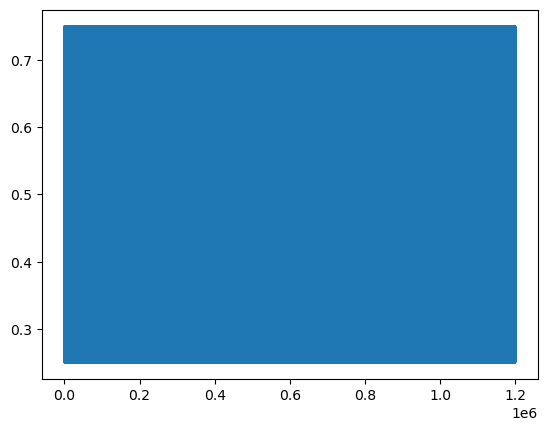

In [6]:
plt.plot(targets)

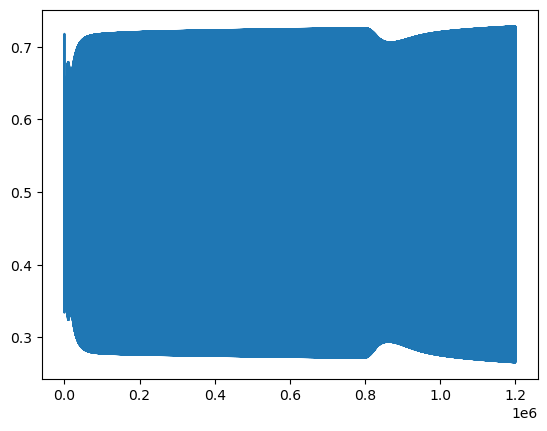

In [7]:
plt.plot(outputs)

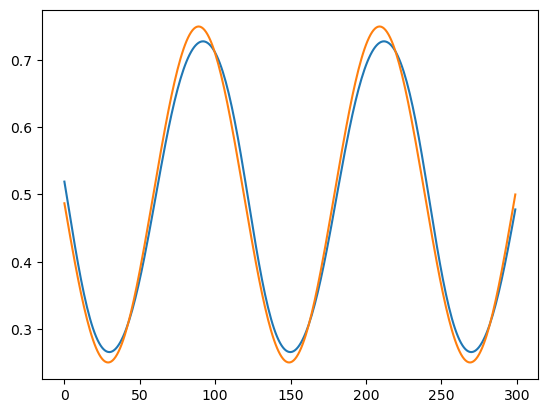

In [8]:
plt.plot(outputs[-300:])
plt.plot(targets[-300:])

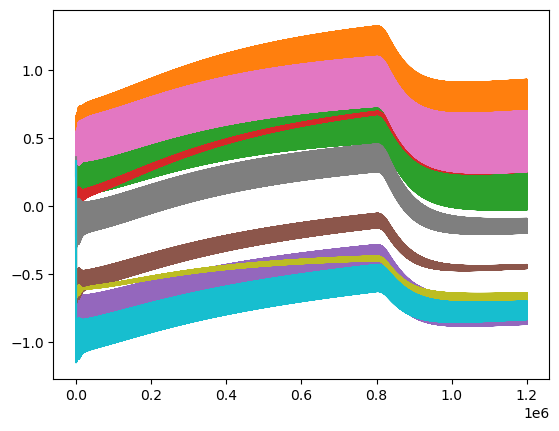

In [9]:
all_states = np.concatenate(states, axis=1)
for i in range(10):
    plt.plot(all_states[i, :])

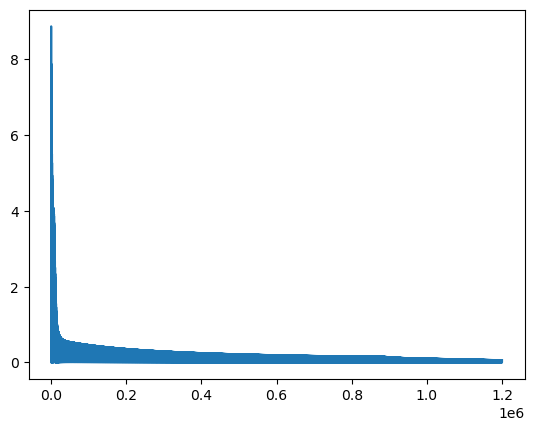

In [10]:
plt.plot(losses)

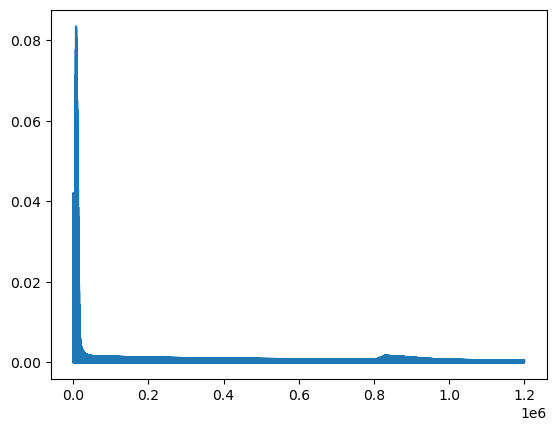

In [11]:
plt.plot(gain_changes)

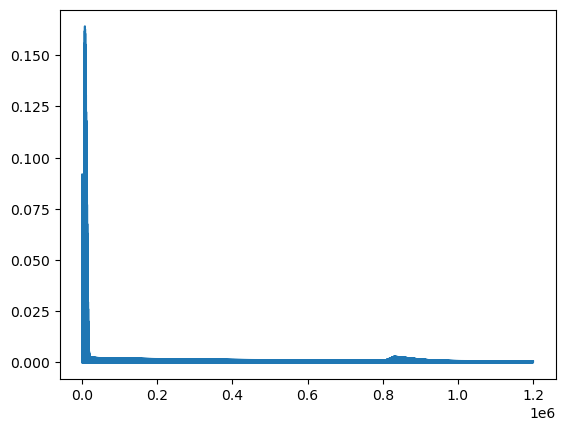

In [12]:
plt.plot(shift_changes)

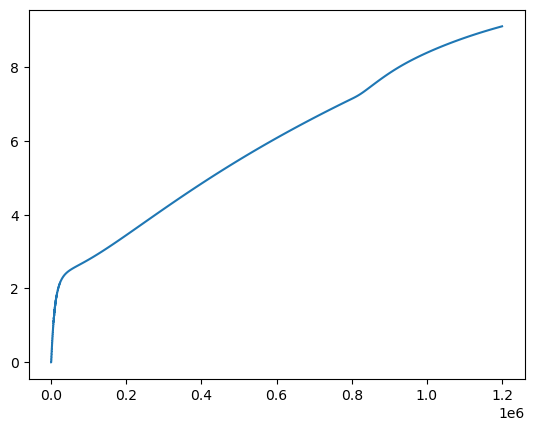

In [13]:
plt.plot(gain_theo_changes)

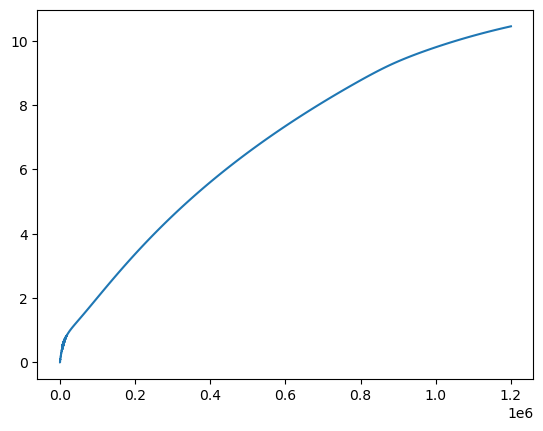

In [14]:
plt.plot(shift_theo_changes)

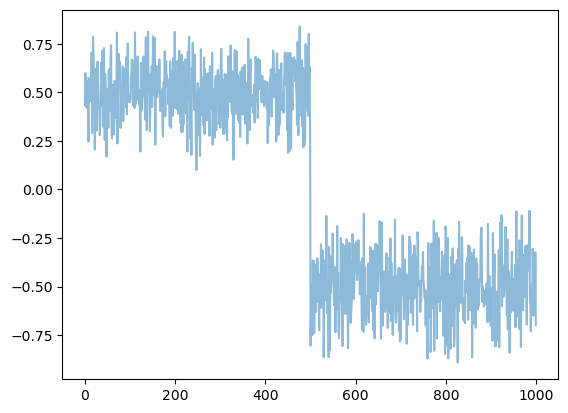

In [15]:
plt.plot(this_output_weight_matrix.flatten(), alpha=0.5)
# plt.plot(init_output_weight_matrix.flatten(), alpha=0.5)

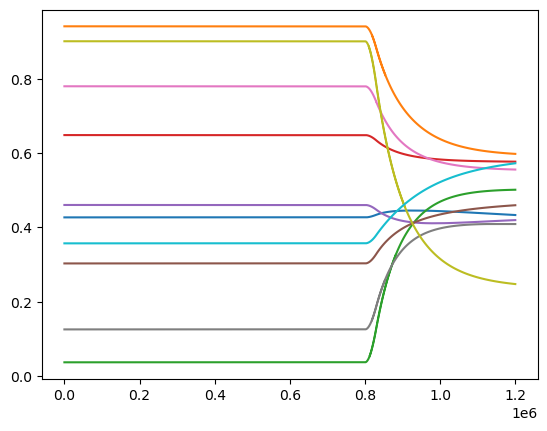

In [16]:
all_output_weights = np.concatenate(output_weights, axis=0).T
for i in range(10):
    plt.plot(all_output_weights[i, :])

In [17]:
network = RNN(weight_matrix, connectivity_matrix, init_state, theo_gain, theo_shift, this_output_weight_matrix, feedback_weight_matrix, 
        timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), shiftout=-2.5, gainout=1.15, target=targets)
states, activations, outputs = network.simulate(120)

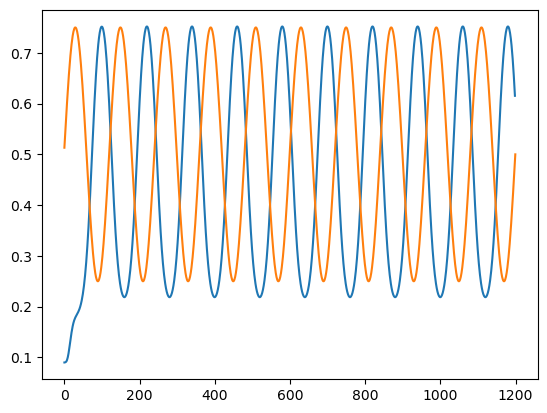

In [18]:
plt.plot(np.array(outputs)+0.09)
plt.plot(targets[0:1200])

### FROM HERE

In [22]:
# Initializing matrix
num_nodes = 1000
np.random.seed(2)

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

# define targets
time_points = np.arange(2000000)
inputs = (np.sin((time_points+1)/60*np.pi))/4 + 0.5
targets = (np.sin((time_points+1)/60*np.pi))/4 + 0.5
targets_for_loss = (np.sin((time_points+50+1)/60*np.pi))/4 + 0.5

In [23]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = 250
inh_weight_sum = 250
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [24]:
# training
has_backprop = True
has_hebbian = False
has_boundary = False
loss_func = nn.MSELoss()
theo_gain = init_gain.copy()
theo_shift = init_shift.copy()
last_gain = init_gain.copy()
last_shift = init_shift.copy()
max_hebbian_lr = 0.003
hebbian_lr_update = max_hebbian_lr / 30000
hebbian_lr = 0


In [25]:
# simulation data
losses, outputs, states, output_weights = [], [], [], []
gain_changes, shift_changes, gain_theo_changes, shift_theo_changes = [], [], [], []

for i in time_points:

    if i > 800000:
        has_hebbian = True
    
    if i > 800000 and not has_boundary:
        # create boundaries
        gain_ub = np.maximum(init_gain, theo_gain)
        gain_lb = np.minimum(init_gain, theo_gain)
        shift_ub = np.maximum(init_shift, theo_shift)
        shift_lb = np.minimum(init_shift, theo_shift)
        has_boundary = True
        print("boundary start!!!")
    
    if has_hebbian and hebbian_lr < max_hebbian_lr:
        hebbian_lr += hebbian_lr_update

    if (i + 1) % 120 == 0:
        has_backprop = True
    else:
        has_backprop = False

    # starting a new period
    if i % 120 == 0:

    # Creating RNN
    # network = RNN(weight_matrix, connectivity_matrix, init_state, init_gain, init_shift, output_weight_matrix, feedback_weight_matrix, 
    #           timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), target=targets, shiftout=-2.5, gainout=1.15)
    # network.i = i
        network = RNN(weight_matrix, connectivity_matrix, init_state, init_gain, init_shift, output_weight_matrix, feedback_weight_matrix, 
                timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), shiftout=-2.5, gainout=1.15, target=inputs)
        opt = torch.optim.SGD([network.gain, network.shift], lr=0.005)
        loss_val = 0
    
    # forward
    network.forward()
    this_output = network.output.squeeze()
    init_state = network.state.detach().numpy()

    # get loss
    # this_target = torch.tensor(targets[i].item())
    this_target = targets[i].item()
    this_target_for_loss = torch.tensor(targets_for_loss[i].item())
    # loss_val += loss_func(this_output, this_target)
    loss_val += loss_func(this_output, this_target_for_loss)

    # backprop
    if has_backprop:
        loss_val.backward()
        opt.step()
        # opt.zero_grad()
    init_gain = network.gain.detach().numpy()
    init_shift = network.shift.detach().numpy()
    gain_theo_change = np.linalg.norm(init_gain - theo_gain, 2)
    shift_theo_change = np.linalg.norm(init_shift - theo_shift, 2)
    gain_change = np.linalg.norm(init_gain - last_gain, 2)
    shift_change = np.linalg.norm(init_shift - last_shift, 2)
    last_gain = init_gain.copy()
    last_shift = init_shift.copy()

    # prepare for hebbian learning
    this_output_val = this_output.detach().item()
    this_activation = network.activation.detach().numpy()
    this_output_weight_matrix = network.output_weight_matrix.detach().numpy()

    # update weights by hebbian learning
    if has_hebbian:
        # Calculate Hebbian weight updates
        # hebbian_update = this_output_val * this_activation.T
        hebbian_update = this_target * this_activation.T
        hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        output_weight_matrix = tmp_output_weight_matrix.copy()
    
    # shrink shift and gain to init value
    if has_boundary:
        # passively narrow the boundaries
        gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
        gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
        shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
        shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
        # pull gains and shifts back to into boundaries
        init_gain = np.minimum(init_gain, gain_ub)
        init_gain = np.maximum(init_gain, gain_lb)
        init_shift = np.minimum(init_shift, shift_ub)
        init_shift = np.maximum(init_shift, shift_lb)

    # save
    losses.append(loss_val.detach().item())
    outputs.append(this_output.detach().item())
    states.append(init_state[0:15,:])
    output_weights.append(this_output_weight_matrix[:,0:15])
    gain_changes.append(gain_change)
    shift_changes.append(shift_change)
    gain_theo_changes.append(gain_theo_change)
    shift_theo_changes.append(shift_theo_change)

boundary start!!!


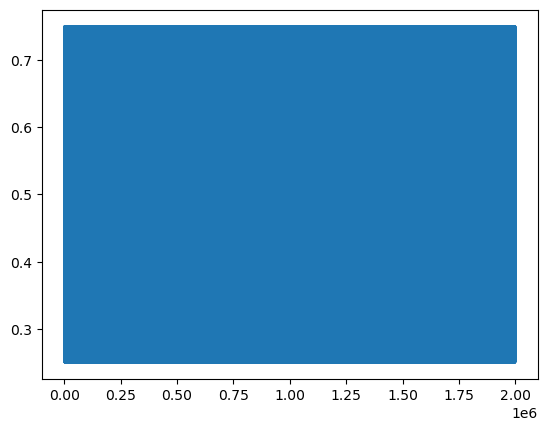

In [26]:
plt.plot(targets)

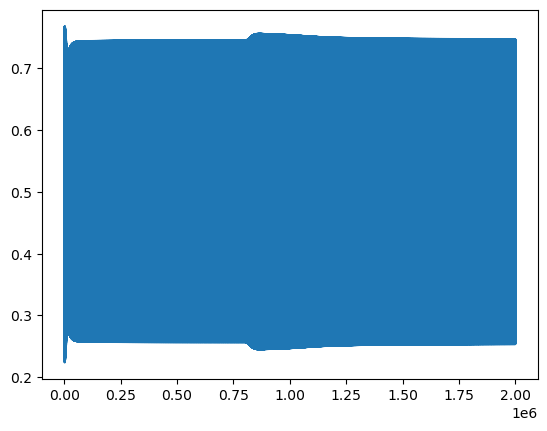

In [27]:
plt.plot(outputs)

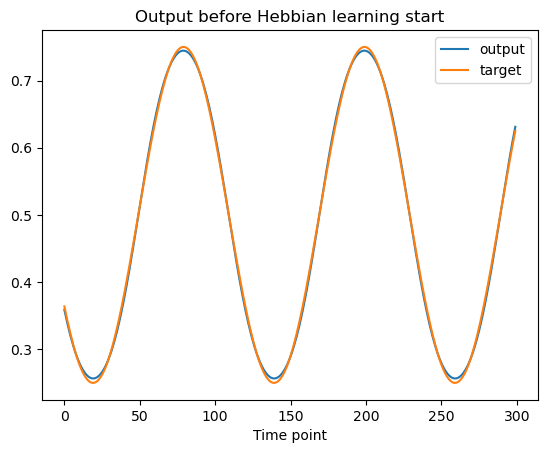

In [28]:
plt.plot(outputs[800000-300:800000], label='output')
# plt.plot(targets[800000-300:800000], label='target')
plt.plot(targets[800000-300+50:800000+50], label='target')
plt.legend()
plt.title('Output before Hebbian learning start')
plt.xlabel('Time point')
if SAVEFIG:
    plt.savefig('fig/FORCE_fbtargethebb_SGDoutput.png')

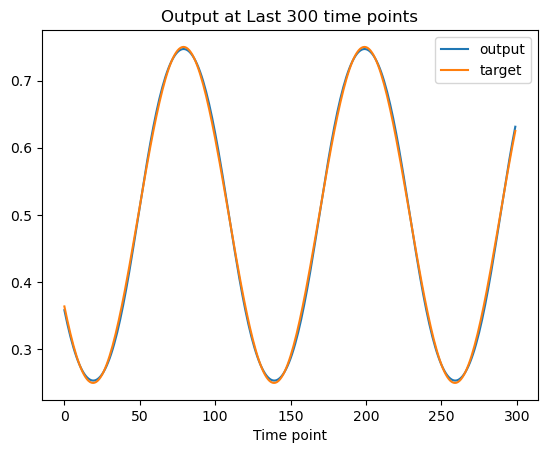

In [29]:
plt.plot(outputs[-300:], label='output')
# plt.plot(targets[-300:], label='target')
plt.plot(targets_for_loss[-300:], label='target')
plt.legend()
plt.title('Output at Last 300 time points')
plt.xlabel('Time point')
if SAVEFIG:
    plt.savefig('fig/FORCE_fbtargethebb_lastoutput.png')

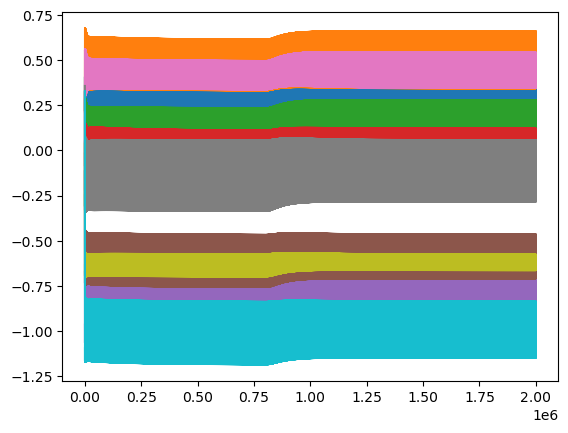

In [30]:
all_states = np.concatenate(states, axis=1)
for i in range(10):
    plt.plot(all_states[i, :])

(0.0, 0.5)

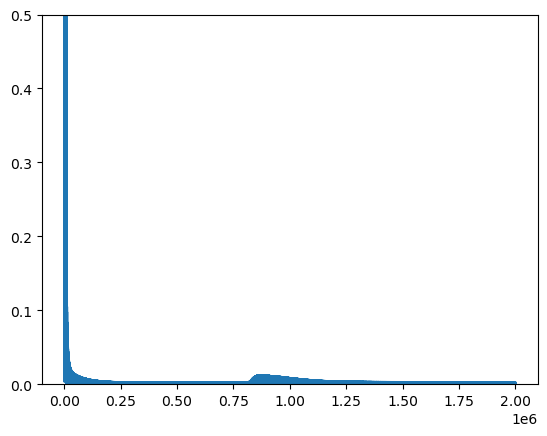

In [31]:
plt.plot(losses)
plt.ylim([0, 0.5])

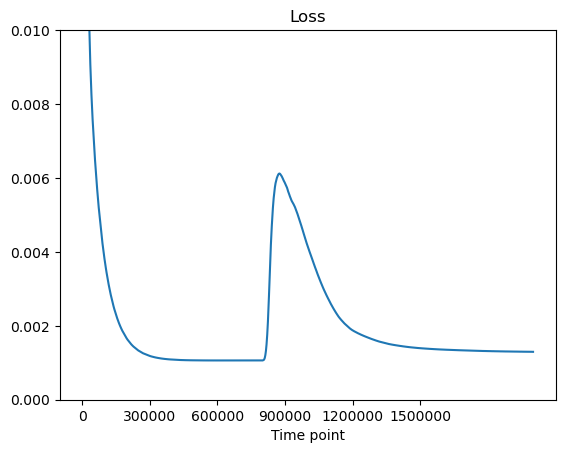

In [32]:
# get the average loss for every 120 time points
avg_losses = []
for i in range(len(losses)//120):
    avg_losses.append(np.mean(losses[i*120:(i+1)*120]))
plt.plot(avg_losses)
plt.ylim([0, 0.01])
plt.xticks(np.arange(0, 1500000//120+1, 2500), np.arange(0, 1500000+1, 2500*120))
plt.xlabel('Time point')
plt.title('Loss')
if SAVEFIG:
    plt.savefig('fig/FORCE_fbtargethebb_loss.png')

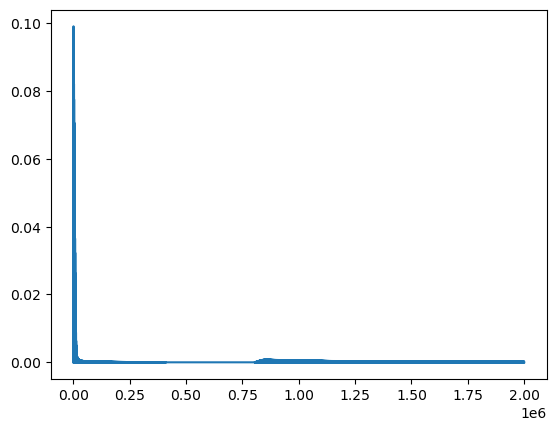

In [33]:
plt.plot(gain_changes)

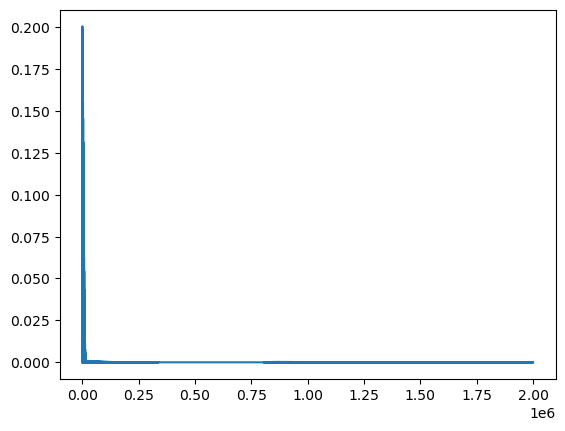

In [34]:
plt.plot(shift_changes)

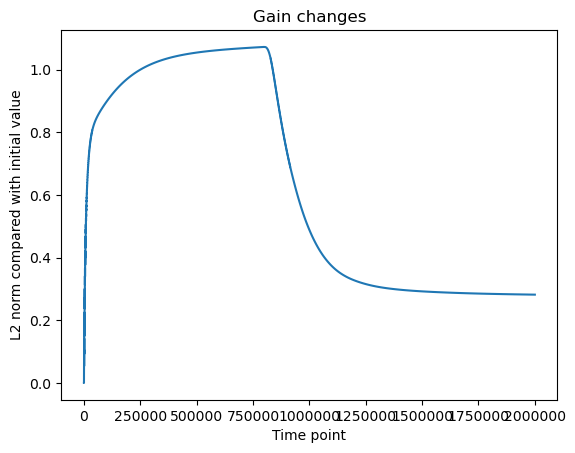

In [35]:
fig, ax = plt.subplots()
plt.plot(gain_theo_changes)
plt.xlabel('Time point')
plt.ylabel('L2 norm compared with initial value')
plt.title('Gain changes')
ax.ticklabel_format(useOffset=False, style='plain')
if SAVEFIG:
    plt.savefig('fig/FORCE_fbtargethebb_theogc.png')

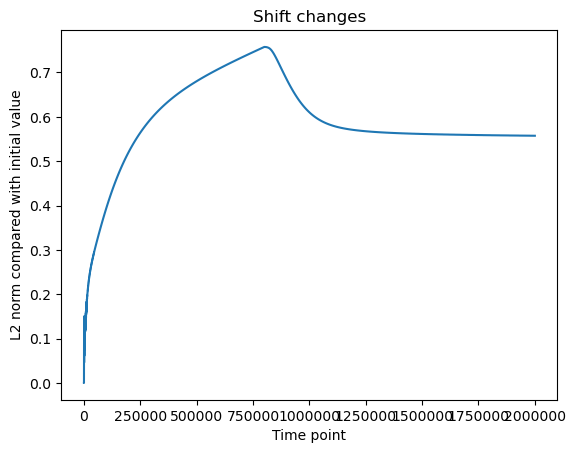

In [36]:
fig, ax = plt.subplots()
plt.plot(shift_theo_changes)
plt.xlabel('Time point')
plt.ylabel('L2 norm compared with initial value')
plt.title('Shift changes')
ax.ticklabel_format(useOffset=False, style='plain')
if SAVEFIG:
    plt.savefig('fig/FORCE_fbtargethebb_theosc.png')

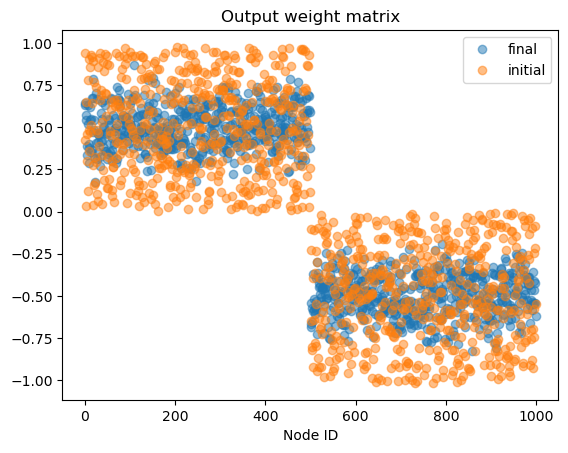

In [37]:
plt.plot(this_output_weight_matrix.flatten(), 'o', alpha=0.5, label='final')
plt.plot(init_output_weight_matrix.flatten(), 'o', alpha=0.5, label='initial')
plt.legend()
plt.title('Output weight matrix')
plt.xlabel('Node ID')
if SAVEFIG:
    plt.savefig('fig/FORCE_fbtargethebb_outweight.png')

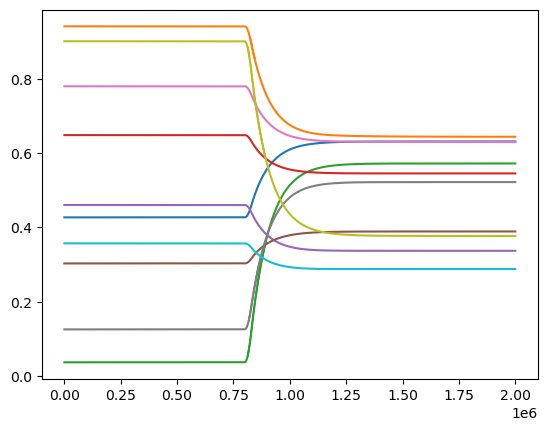

In [38]:
all_output_weights = np.concatenate(output_weights, axis=0).T
for i in range(10):
    plt.plot(all_output_weights[i, :])

In [39]:
network = RNN(weight_matrix, connectivity_matrix, init_state, theo_gain, theo_shift, this_output_weight_matrix, feedback_weight_matrix, 
        timestep=0.1, g=1.5, activation_func=nn.Sigmoid(), output_nonlinearity=nn.Sigmoid(), shiftout=-2.5, gainout=1.15, target=targets)
states_nogain, activations_nogain, outputs_nogain = network.simulate(120)

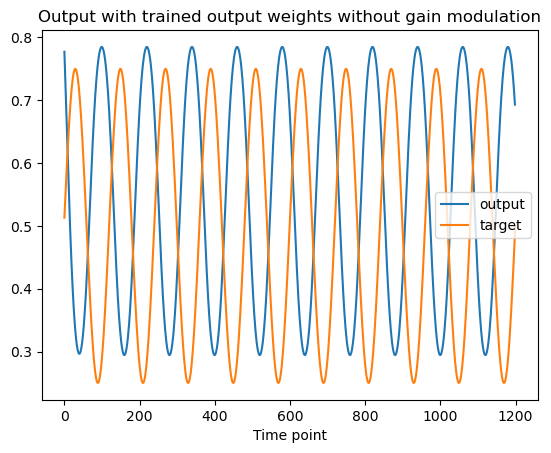

In [40]:
plt.plot(np.array(outputs_nogain), label='output')
plt.plot(targets[0:1200], label='target')
# plt.plot(np.array(outputs_nogain), label='output (aligned)') # 0.11, before phase adjustment
plt.xlabel('Time point')
plt.legend()
plt.title('Output with trained output weights without gain modulation')
if SAVEFIG:
    plt.savefig('fig/FORCE_fbtargethebb_nogainoutput.png')

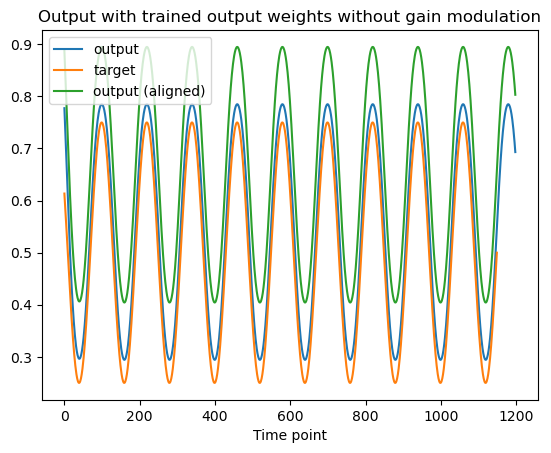

In [41]:
plt.plot(np.array(outputs_nogain), label='output')
plt.plot(targets[0+50:1200], label='target')
plt.plot(np.array(outputs_nogain)+0.11, label='output (aligned)')
plt.xlabel('Time point')
plt.legend()
plt.title('Output with trained output weights without gain modulation')
if SAVEFIG:
    plt.savefig('fig/FORCE_fbtargethebb_nogainoutput.png')

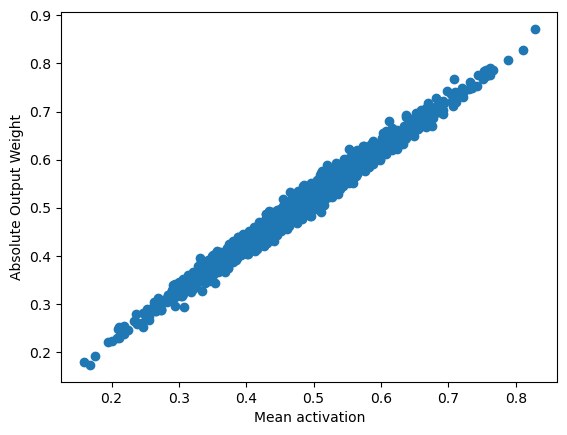

In [53]:
mean_activations = np.mean(np.concatenate(activations_nogain, axis=1), axis=1)
plt.scatter(mean_activations, np.abs(this_output_weight_matrix.flatten()))
plt.xlabel('Mean activation')
plt.ylabel('Absolute Output Weight')
if SAVEFIG:
    plt.savefig('fig/FORCE_fbtargethebb_weightcorractv.png')